# Occupancy detection
Data set obtained from http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+# 

The objective is to create a model that can predict occupancy of a room given measurements of temperature, humidity, light intensity, CO2 and Humidity Ratio.

Let's compare logistic regression and simple NN and then change the topology of the NN to increase hidden layers (deep learning)

In [78]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from dateutil import parser
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.core.pylabtools import figsize

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

In [54]:
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
def plot_loss_accuracy(history):
    df = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(10, 10))
    df.plot(ylim=(0, max(1, df.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [4]:
def plot_confusion_matrix(X, y, y_pred):
    #y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(10, 10))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

In [5]:
train = pd.read_csv('./Data/occupancy_data/datatraining.txt')
test = pd.read_csv('./Data/occupancy_data/datatest.txt')
test2 = pd.read_csv('./Data/occupancy_data/datatest2.txt')

In [6]:
train.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
7438,2015-02-09 21:48:00,20.500000,33.500000,0.000000,712.500000,0.005000,0
484,2015-02-05 01:53:59,21.100000,25.100000,0.000000,441.500000,0.003881,0
7599,2015-02-10 00:29:00,20.290000,33.000000,0.000000,488.000000,0.004861,0
4367,2015-02-07 18:36:59,20.200000,22.890000,0.000000,437.000000,0.003345,0
3887,2015-02-07 10:37:00,21.856667,18.166667,311.333333,462.000000,0.002937,0
3478,2015-02-07 03:48:00,19.790000,19.245000,0.000000,440.000000,0.002739,0
3001,2015-02-06 19:51:00,20.500000,19.290000,0.000000,484.000000,0.002869,0
6112,2015-02-08 23:42:00,19.500000,27.200000,0.000000,452.666667,0.003809,0
5868,2015-02-08 19:38:00,19.290000,27.700000,0.000000,435.000000,0.003829,0
5261,2015-02-08 09:30:59,19.290000,30.890000,75.500000,435.000000,0.004273,0


In [7]:
all_data = train.append(test)
all_data = all_data.append(test2)
all_data.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1556,2015-02-05 19:46:00,21.100000,19.290000,0.0,503.50,0.002978,0
3444,2015-02-07 03:14:00,19.840000,19.100000,0.0,437.00,0.002727,0
1536,2015-02-03 13:34:59,23.200000,25.650000,638.0,938.25,0.004511,0
2319,2015-02-04 02:38:00,20.700000,25.000000,0.0,494.00,0.003770,0
3515,2015-02-14 01:21:59,19.890000,35.500000,0.0,501.00,0.005103,0
9625,2015-02-18 07:12:00,20.700000,27.000000,0.0,1489.00,0.004074,0
4352,2015-02-07 18:22:00,20.290000,22.600000,0.0,434.00,0.003321,0
2483,2015-02-04 05:22:00,20.666667,24.463333,0.0,467.00,0.003681,0
93,2015-02-11 16:20:00,21.890000,30.166667,441.0,768.00,0.004903,1
6255,2015-02-15 23:02:00,20.290000,30.500000,0.0,734.50,0.004490,0


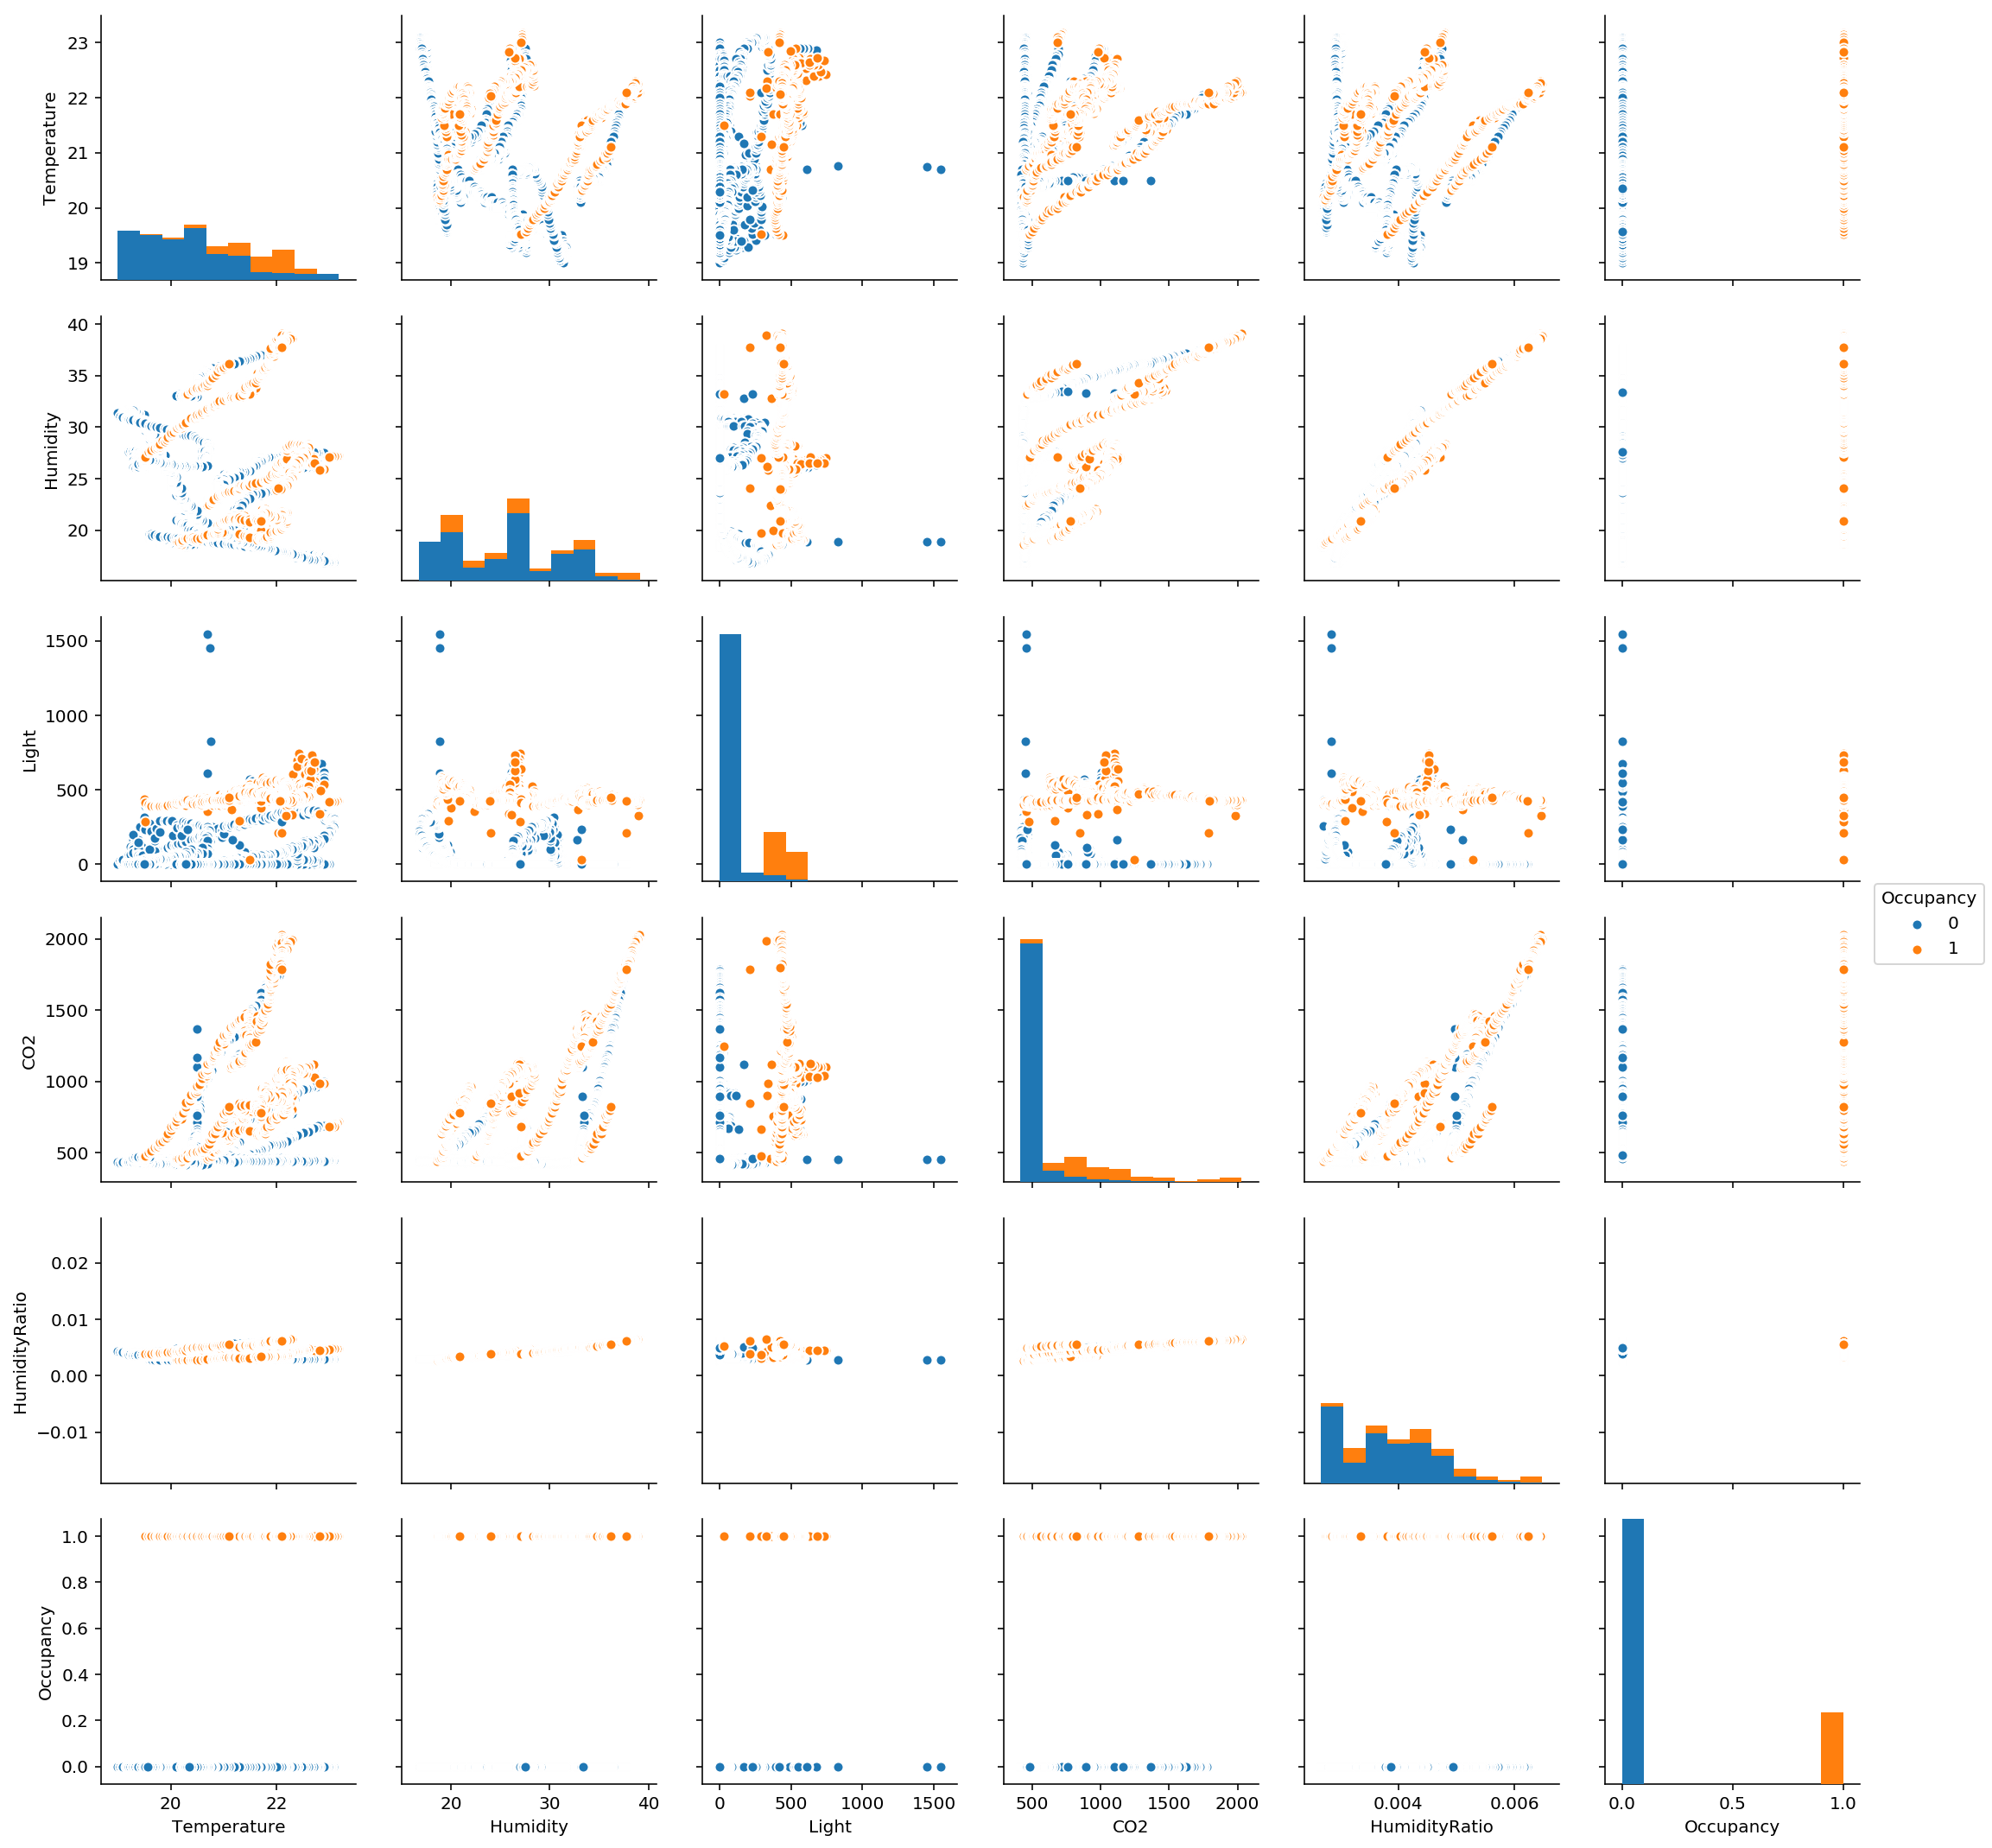

In [8]:
sns.pairplot(train, hue='Occupancy')

In [9]:
c = train.drop('Occupancy', axis=1).corr().abs()

s = c.unstack()
print(type(s))
so = s.sort_values(ascending=False, kind="quicksort")
print(so)

<class 'pandas.core.series.Series'>
HumidityRatio  HumidityRatio    1.000000
CO2            CO2              1.000000
Humidity       Humidity         1.000000
Light          Light            1.000000
Temperature    Temperature      1.000000
HumidityRatio  Humidity         0.955198
Humidity       HumidityRatio    0.955198
Light          CO2              0.664022
CO2            Light            0.664022
Temperature    Light            0.649942
Light          Temperature      0.649942
HumidityRatio  CO2              0.626556
CO2            HumidityRatio    0.626556
               Temperature      0.559894
Temperature    CO2              0.559894
Humidity       CO2              0.439023
CO2            Humidity         0.439023
Light          HumidityRatio    0.230420
HumidityRatio  Light            0.230420
Temperature    HumidityRatio    0.151762
HumidityRatio  Temperature      0.151762
Humidity       Temperature      0.141759
Temperature    Humidity         0.141759
Light          Humidi

Quick insights from the plots (and table) above:
- Humidity and Humidity ratio seem to be highly corralated to each other (not independent). We might not need these two features for our ML model
- The pairs (CO2 <-> Ligth) and (Light <-> Temperature) show distint clusters of Occupancy status that look linearly separable

In [10]:
train['date'] = np.array([parser.parse(x) for x in train['date'].values])
time_secs = train['date'].dt.hour*3600+train['date'].dt.minute*60 + train['date'].dt.second

# Do the same for the test data set... nothing we are not manipulating the data... just adding features for time
all_data['date'] = np.array([parser.parse(x) for x in all_data['date'].values])
test_secs = all_data['date'].dt.hour*3600+all_data['date'].dt.minute*60 + all_data['date'].dt.second

We need a transformation for time, we will be assuming a cycle of 24 hours since training data is less than one week. If more training data is available then we can look at occupancy at different time cycles (days, weeks, months, etc). Thus, at the moment we want to only explore if occupancy varies based on the time of the day

In [11]:
sec_day = 24*60*60

train['sin_time'] = np.sin(2*np.pi*time_secs/sec_day)
train['cos_time'] = np.cos(2*np.pi*time_secs/sec_day)

all_data['sin_time'] = np.sin(2*np.pi*test_secs/sec_day)
all_data['cos_time'] = np.cos(2*np.pi*test_secs/sec_day)

train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_time,cos_time
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,-0.999229,-0.039260
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,-0.999388,-0.034972
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,-0.999534,-0.030539
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,-0.999657,-0.026177
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,-0.999762,-0.021815


In [12]:
train.set_index('date', inplace=True)
all_data.set_index('date', inplace=True)

In [13]:
train.head(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_time,cos_time
date,,,,,,,,
2015-02-04 17:51:00,23.180,27.2720,426.0,721.250000,0.004793,1,-0.999229,-3.925982e-02
2015-02-04 17:51:59,23.150,27.2675,429.5,714.000000,0.004783,1,-0.999388,-3.497217e-02
2015-02-04 17:53:00,23.150,27.2450,426.0,713.500000,0.004779,1,-0.999534,-3.053851e-02
2015-02-04 17:54:00,23.150,27.2000,426.0,708.250000,0.004772,1,-0.999657,-2.617695e-02
2015-02-04 17:55:00,23.100,27.2000,426.0,704.500000,0.004757,1,-0.999762,-2.181489e-02
2015-02-04 17:55:59,23.100,27.2000,419.0,701.000000,0.004757,1,-0.999846,-1.752512e-02
2015-02-04 17:57:00,23.100,27.2000,419.0,701.666667,0.004757,1,-0.999914,-1.308960e-02
2015-02-04 17:57:59,23.100,27.2000,419.0,699.000000,0.004757,1,-0.999961,-8.799255e-03
2015-02-04 17:58:59,23.100,27.2000,419.0,689.333333,0.004757,1,-0.999990,-4.436031e-03


In [14]:
all_data.sample(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_time,cos_time
date,,,,,,,,
2015-02-17 06:38:00,20.50,30.39,0.0,754.00,0.004533,0,0.986286,-0.165048
2015-02-16 03:08:59,20.39,26.89,0.0,873.00,0.003980,0,0.734273,0.678854
2015-02-08 06:22:00,19.20,31.70,0.0,431.50,0.004361,0,0.995396,-0.095846
2015-02-05 04:34:59,20.89,24.15,0.0,440.00,0.003685,0,0.931982,0.362506
2015-02-13 18:52:00,21.20,32.40,0.0,528.00,0.005049,0,-0.974370,0.224951
2015-02-03 15:08:00,23.10,29.84,469.0,1235.75,0.005223,1,-0.731354,-0.681998
2015-02-07 22:44:00,19.70,28.50,0.0,430.50,0.004042,0,-0.325568,0.945519
2015-02-17 11:21:00,21.39,32.45,433.0,1092.00,0.005117,1,0.169350,-0.985556
2015-02-18 04:49:00,20.79,26.10,0.0,1510.00,0.003959,0,0.952396,0.304864


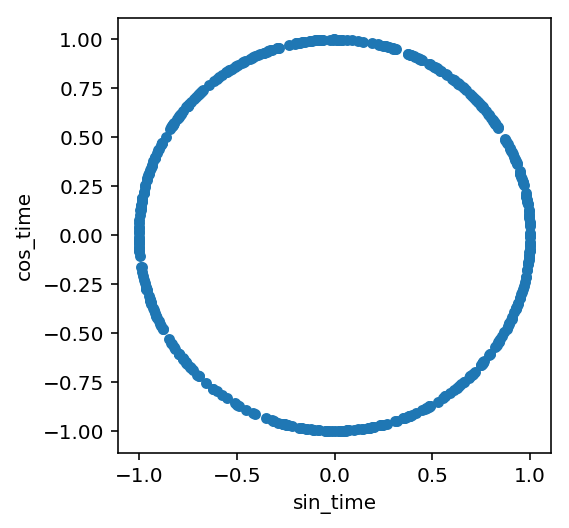

In [15]:
train.sample(500).plot.scatter('sin_time','cos_time').set_aspect('equal')

In [16]:
train.head(2).values

array([[ 2.31800000e+01,  2.72720000e+01,  4.26000000e+02,
         7.21250000e+02,  4.79298818e-03,  1.00000000e+00,
        -9.99229036e-01, -3.92598158e-02],
       [ 2.31500000e+01,  2.72675000e+01,  4.29500000e+02,
         7.14000000e+02,  4.78344095e-03,  1.00000000e+00,
        -9.99388286e-01, -3.49721744e-02]])

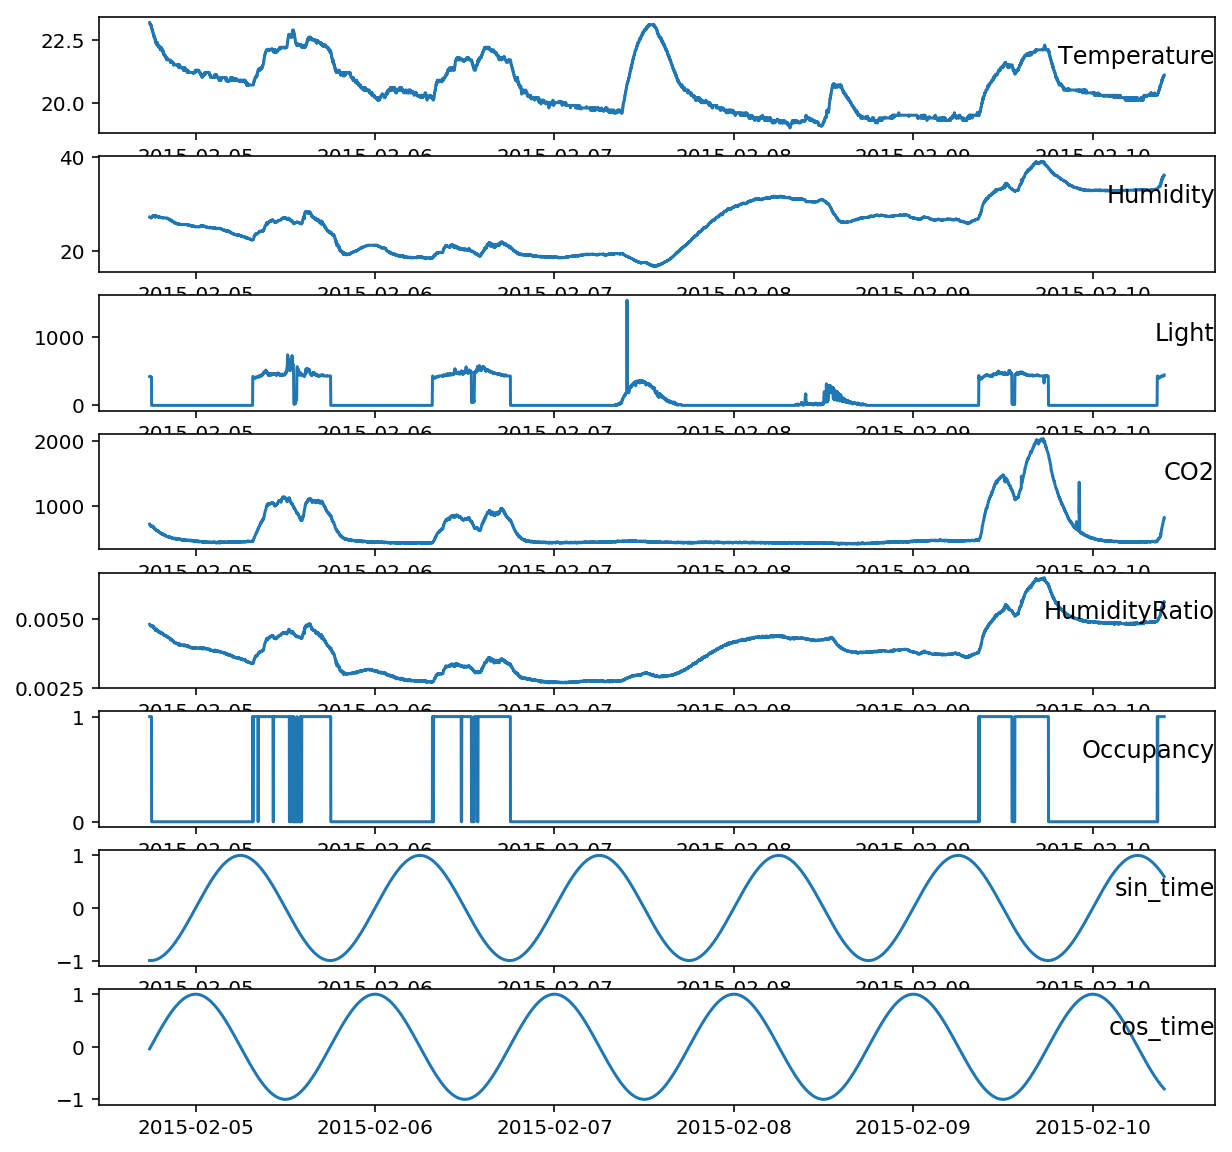

In [17]:
figsize(10,10)
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(train.index,train.values[:, group])
    plt.title(train.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [18]:
# figsize(10,10)
# # plot each column
# plt.figure()
# plt.plot(all_data.index,all_data.values[:, 5])
# plt.title(all_data.columns[5], y=0.5, loc='right')
# plt.show()

In [19]:
X_train = train.drop(['Occupancy', 'HumidityRatio'], axis=1).values
# X_train = train.drop(['Occupancy'], axis=1).values
y_train = train['Occupancy'].values

X_test = all_data.drop(['Occupancy', 'HumidityRatio'], axis=1).values
# X_test = test.drop(['Occupancy'], axis=1).values
y_test = all_data['Occupancy'].values


# Normalizing features

In [72]:
scaler_sig = MinMaxScaler(feature_range=(0, 1))
scaled_sig = scaler_sig.fit_transform(X_train)
scaler_tanh = MinMaxScaler(feature_range=(-1, 1))
scaled_tanh = scaler_tanh.fit_transform(X_train)

scaled_test_sig = scaler_sig.fit_transform(X_test)
scaled_test_tanh = scaler_tanh.fit_transform(X_test)

# Linear Regression

In [50]:
lr = LogisticRegression()
lr.fit(scaled_sig, y_train)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

LR coefficients: [[-1.69481671 -0.76932301 18.15291773  7.5689766   0.59948271 -0.82191802]]
LR intercept: [-4.26854397]


             precision    recall  f1-score   support

          0       0.98      0.98      0.98     15810
          1       0.93      0.92      0.93      4750

avg / total       0.97      0.97      0.97     20560

96.54182879377431


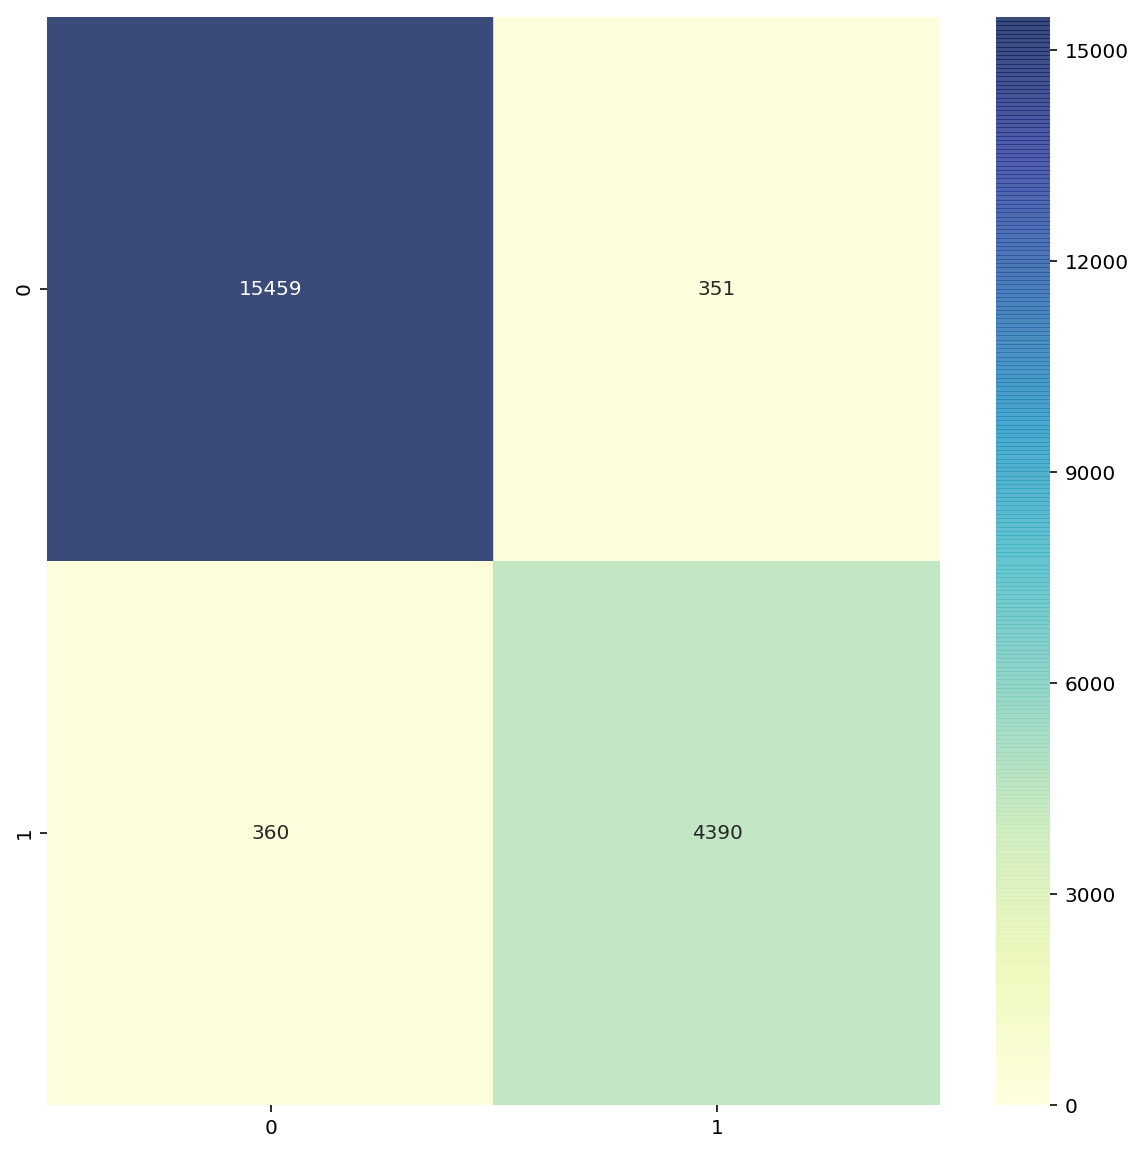

In [81]:
y_pred = lr.predict(scaled_test_sig)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(scaled_test_sig, y_test, y_pred)
score_lr = accuracy_score(y_test, y_pred)*100
print(score_lr)

Actually it is not that bad

# Neural networks
Let's see if we can do better with NN

# Shallow Model

<Figure size 720x720 with 0 Axes>

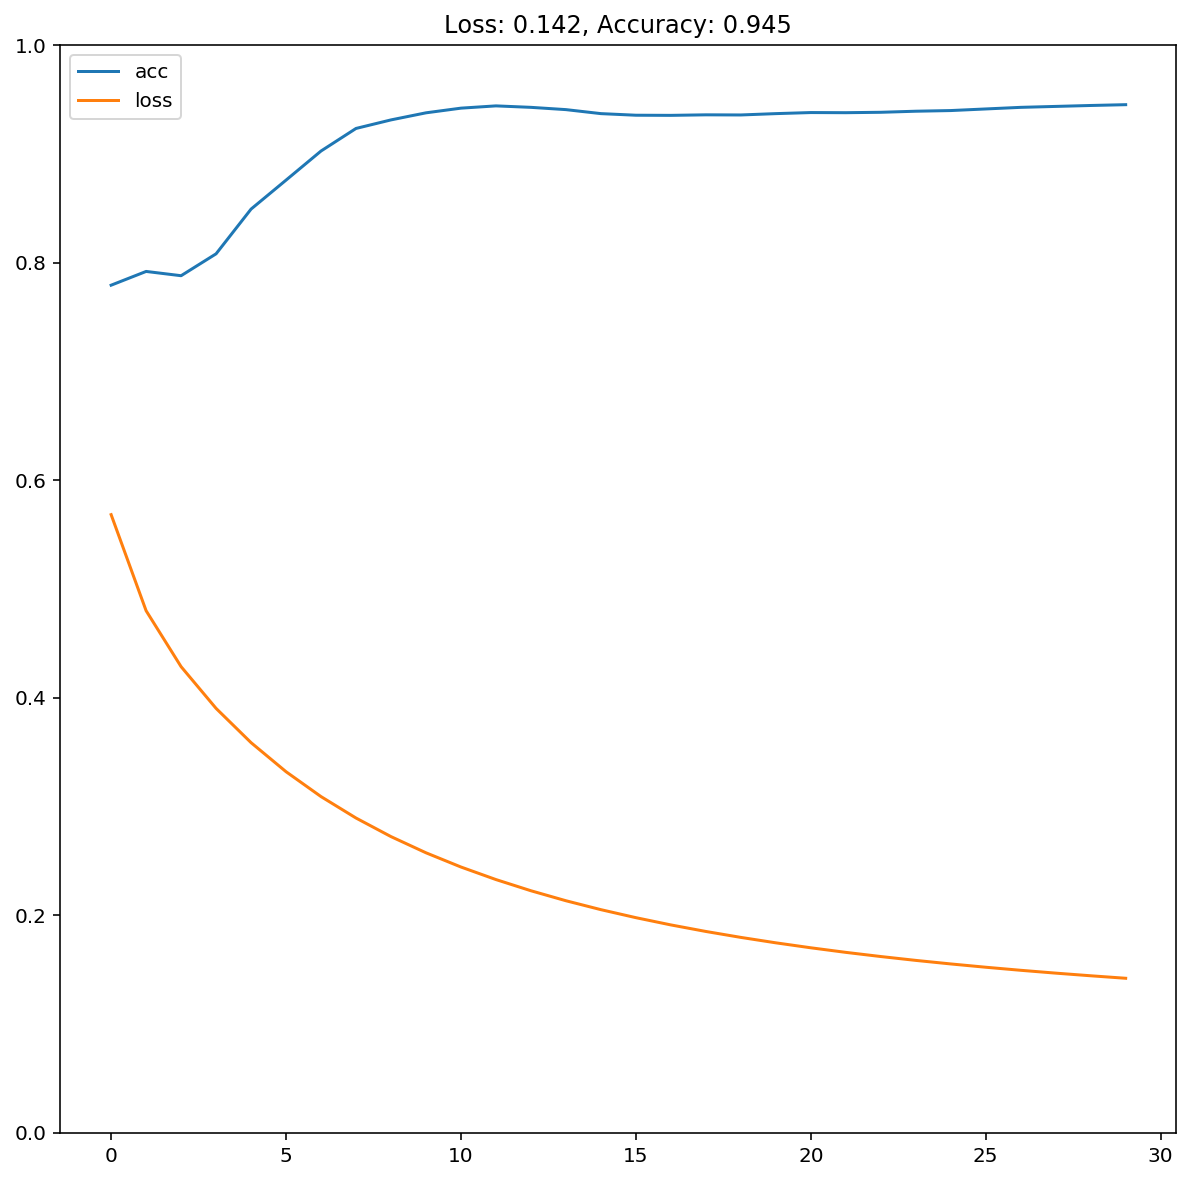

In [55]:
def nn_no_hidden_layers():
    model = Sequential()
    model.add(Dense(1, input_shape=(scaled_sig.shape[1],), activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

lr_model=nn_no_hidden_layers()
his_no_hidden_layers=lr_model.fit(scaled_sig, y_train, verbose=0, epochs=30)

plot_loss_accuracy(his_no_hidden_layers)

             precision    recall  f1-score   support

          0       0.94      0.97      0.96     15810
          1       0.88      0.81      0.85      4750

avg / total       0.93      0.93      0.93     20560



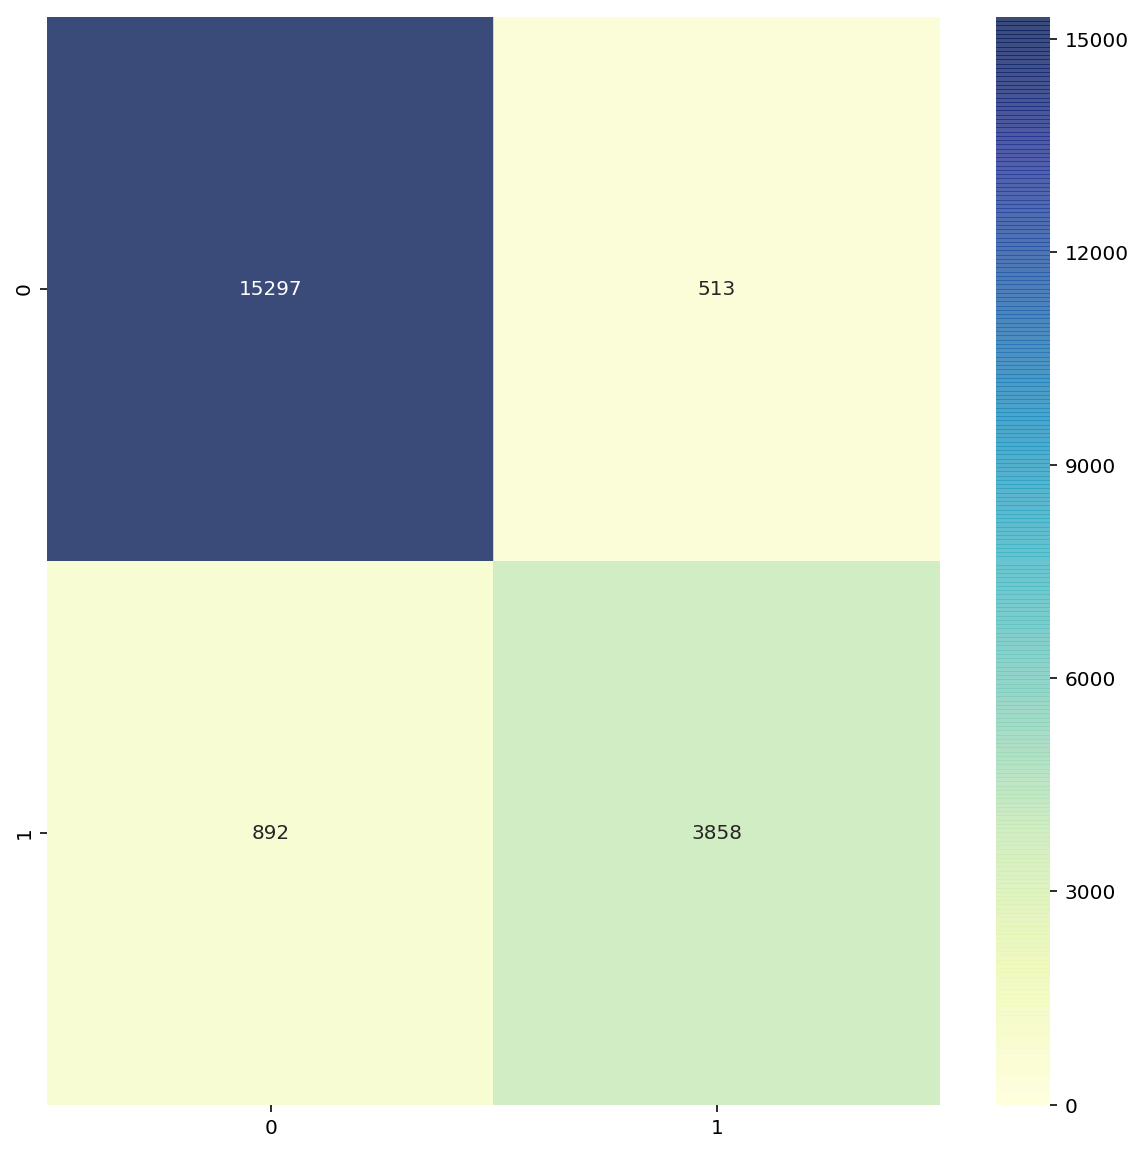

In [57]:
y_pred_shallow = lr_model.predict_classes(scaled_test_sig, verbose=0)
print(classification_report(y_test, y_pred_shallow))
plot_confusion_matrix(scaled_test_sig, y_test, y_pred_shallow)

In [58]:
model = KerasClassifier(build_fn=nn_no_hidden_layers, epochs=5, verbose=0)
scores = cross_val_score(model, scaled_test_sig, y_test, cv=5)

print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[0.74100195 0.96035992 0.82879377 0.92339494 0.93458171]
Accuracy: 87.76% (+/- 16.31%)


Standard deviation too high!

# Getting Deep

Epoch 1/30
8143/8143 [==============================] - 1s 140us/step - loss: 0.5028 - acc: 0.7877
Epoch 2/30
8143/8143 [==============================] - 1s 66us/step - loss: 0.2530 - acc: 0.8810
Epoch 3/30
8143/8143 [==============================] - 0s 59us/step - loss: 0.1555 - acc: 0.9466
Epoch 4/30
8143/8143 [==============================] - 1s 64us/step - loss: 0.1063 - acc: 0.9679
Epoch 5/30
8143/8143 [==============================] - 1s 67us/step - loss: 0.0738 - acc: 0.9827
Epoch 6/30
8143/8143 [==============================] - 0s 60us/step - loss: 0.0706 - acc: 0.9802
Epoch 7/30
8143/8143 [==============================] - 0s 56us/step - loss: 0.0552 - acc: 0.9871
Epoch 8/30
8143/8143 [==============================] - 1s 64us/step - loss: 0.0523 - acc: 0.9880
Epoch 9/30
8143/8143 [==============================] - 0s 60us/step - loss: 0.0507 - acc: 0.9881
Epoch 10/30
8143/8143 [==============================] - 0s 61us/step - loss: 0.0501 - acc: 0.9878
Epoch 11/30
8143/8

<Figure size 720x720 with 0 Axes>

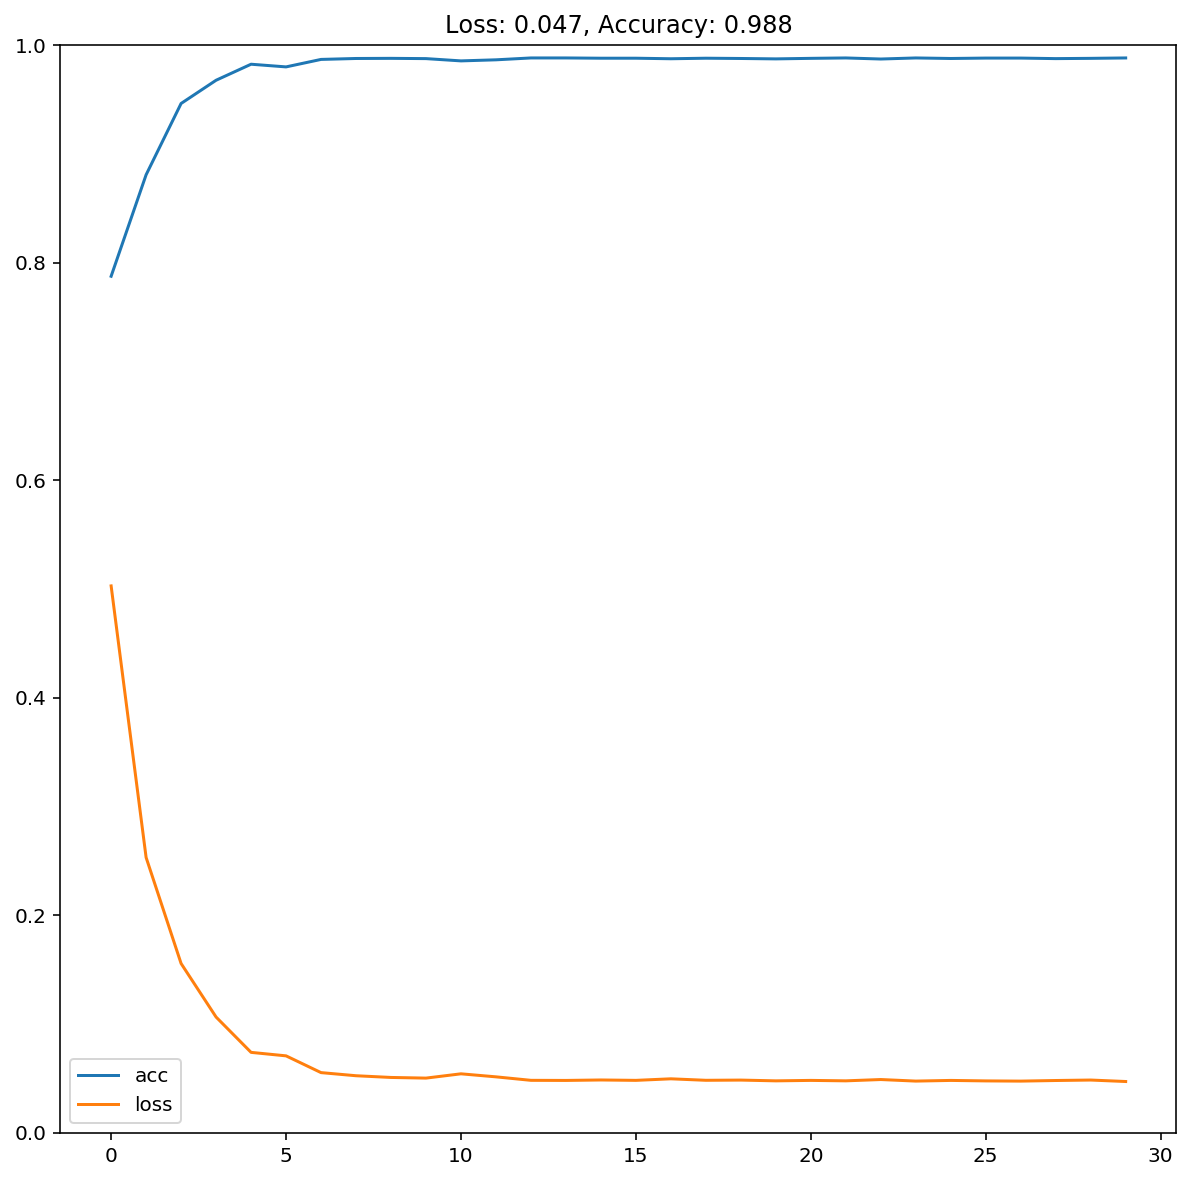

In [59]:
def five_hidden_layers():
    model = Sequential()
    model.add(Dense(128, input_shape=(scaled_sig.shape[1],), activation='sigmoid'))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

deep_model = five_hidden_layers()
deep_history = deep_model.fit(scaled_sig, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     15810
          1       0.94      1.00      0.97      4750

avg / total       0.99      0.99      0.99     20560



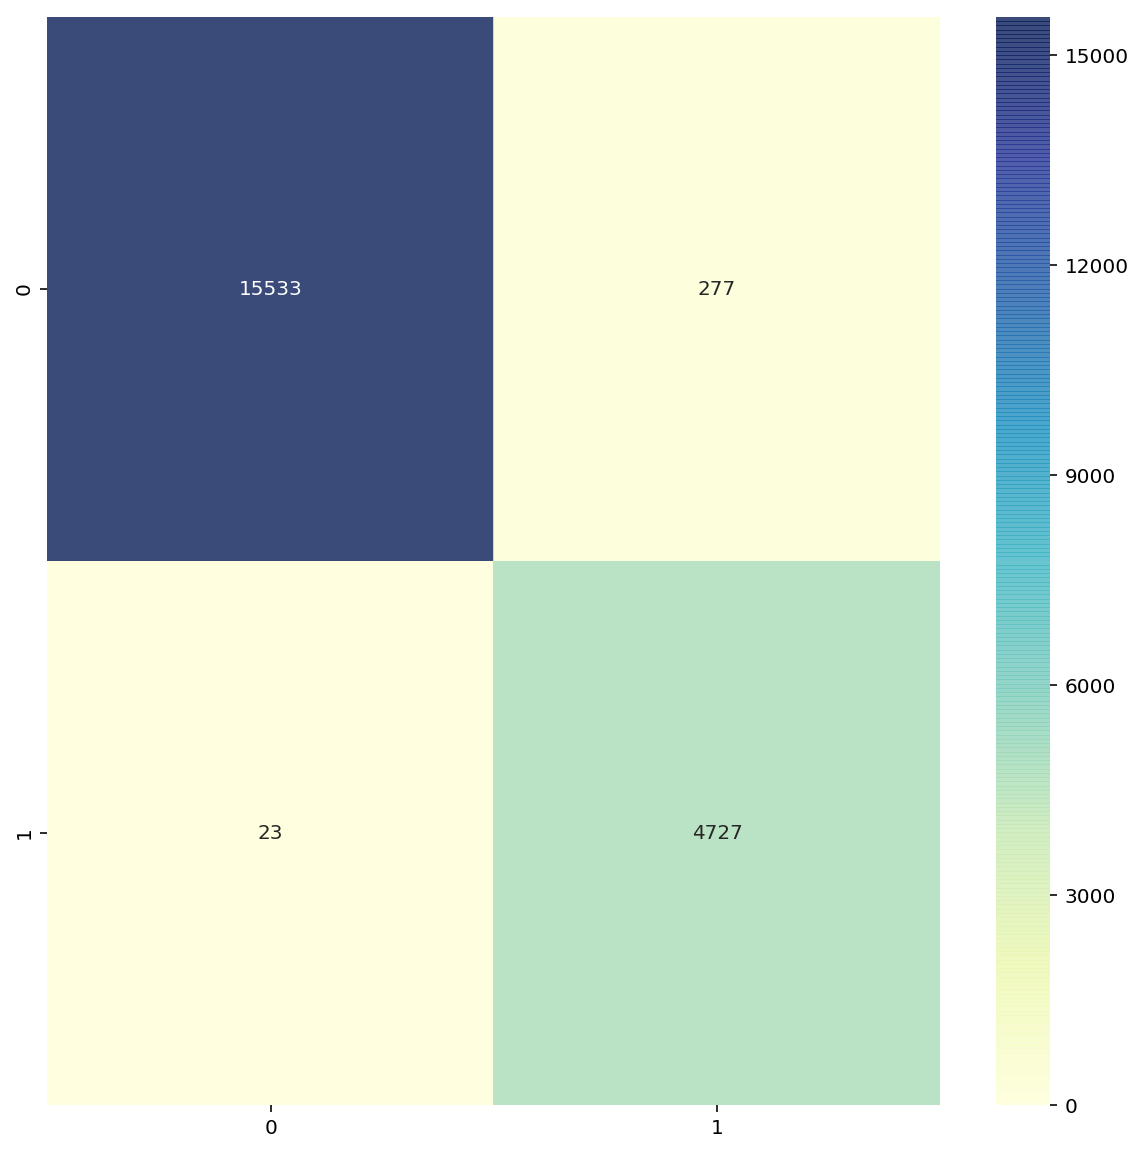

In [61]:
y_pred_deep  =  deep_model.predict_classes(scaled_test_sig, verbose=0)
print(classification_report(y_test, y_pred_deep))
plot_confusion_matrix(scaled_test_sig, y_test, y_pred_deep)

In [63]:
model_deep = KerasClassifier(build_fn=five_hidden_layers, epochs=5, verbose=0)
scores_deep = cross_val_score(model_deep, scaled_test_sig, y_test, cv=5)

print(scores_deep)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores_deep.mean(), 100*scores_deep.std()*2))

[0.72251946 0.99392023 0.98249027 0.98224708 0.98273346]
Accuracy: 93.28% (+/- 21.04%)


# Deeper Model

Epoch 1/30
8143/8143 [==============================] - 4s 517us/step - loss: 0.1244 - acc: 0.9618
Epoch 2/30
8143/8143 [==============================] - 1s 146us/step - loss: 0.0575 - acc: 0.9867
Epoch 3/30
8143/8143 [==============================] - 1s 156us/step - loss: 0.0559 - acc: 0.9859
Epoch 4/30
8143/8143 [==============================] - 1s 155us/step - loss: 0.0511 - acc: 0.9858
Epoch 5/30
8143/8143 [==============================] - 1s 154us/step - loss: 0.0500 - acc: 0.9867
Epoch 6/30
8143/8143 [==============================] - 1s 153us/step - loss: 0.0428 - acc: 0.9881
Epoch 7/30
8143/8143 [==============================] - 1s 155us/step - loss: 0.0479 - acc: 0.9859
Epoch 8/30
8143/8143 [==============================] - 1s 156us/step - loss: 0.0472 - acc: 0.9870
Epoch 9/30
8143/8143 [==============================] - 1s 151us/step - loss: 0.0444 - acc: 0.9880
Epoch 10/30
8143/8143 [==============================] - 1s 166us/step - loss: 0.0378 - acc: 0.9885
Epoch 11/

<Figure size 720x720 with 0 Axes>

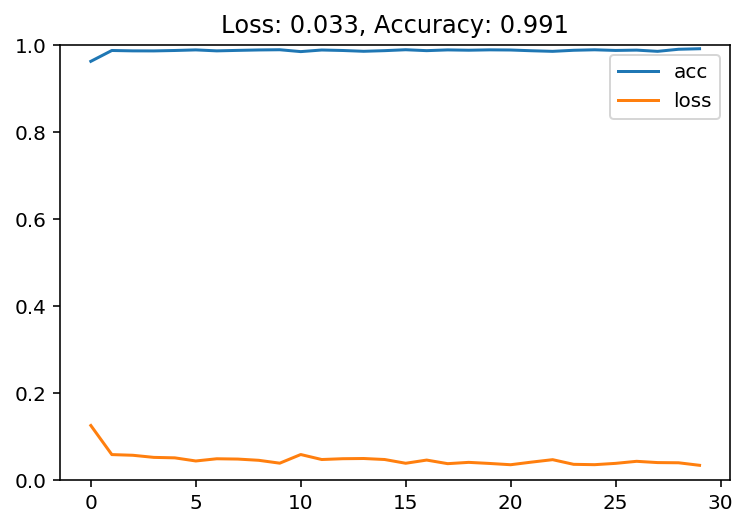

In [88]:
def ten_hidden_layers():
    model = Sequential()
    model.add(Dense(128, input_shape=(scaled_tanh.shape[1],), activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

deeper_model = ten_hidden_layers()
deeper_history = deeper_model.fit(scaled_tanh, y_train, verbose=1, epochs=30)
plot_loss_accuracy(deeper_history)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98     15810
          1       0.92      0.93      0.93      4750

avg / total       0.97      0.97      0.97     20560



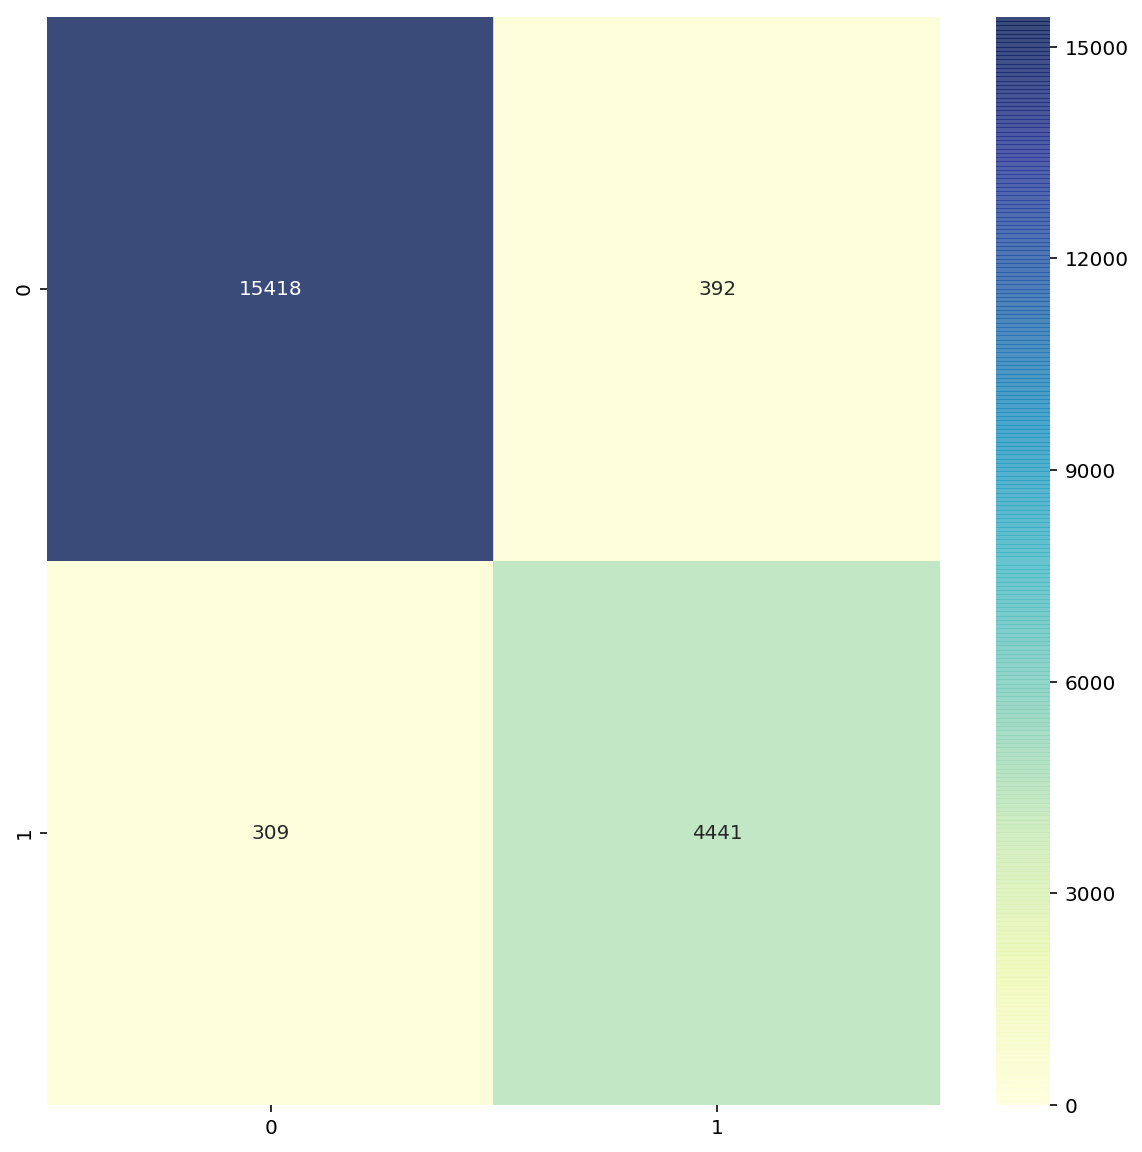

In [89]:
y_pred_deeper = deeper_model.predict_classes(scaled_test_tanh, verbose=0)
print(classification_report(y_test, y_pred_deeper))
plot_confusion_matrix(scaled_test_tanh, y_test, y_pred_deeper)

In [90]:
model_deeper = KerasClassifier(build_fn=ten_hidden_layers, epochs=5, verbose=0)
scores_deeper = cross_val_score(model_deeper, scaled_test_tanh, y_test, cv=5)

print(scores_deeper)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores_deeper.mean(), 100*scores_deeper.std()*2))

[0.97835603 0.99854086 0.98249027 0.99148833 0.98808366]
Accuracy: 98.78% (+/- 1.40%)


In [91]:
d = [["Logistic_Regression", score_lr, None],
     ["No_Hidden_Layers", 100*scores.mean(), 100*scores.std()*2], 
     ["Five_Hidden_Layers", 100*scores_deep.mean(), 100*scores_deep.std()*2],
     ["Ten_Hidden_Layers", 100*scores_deeper.mean(), 100*scores_deeper.std()*2]]
df_score = pd.DataFrame(data=d, columns=["NN", "Accuracy", "Std"])
df_score

,NN,Accuracy,Std
0,Logistic_Regression,96.541829,NaN
1,No_Hidden_Layers,87.762646,16.305673
2,Five_Hidden_Layers,93.278210,21.044919
3,Ten_Hidden_Layers,98.779183,1.404084


# Remarks
Logistic regression seems to return a good model for this application (from the pair plots it looks that data might be linearly separable. 

Accuracy of deep models looks better than accurary of shallow model. However, I need to optimize (fine tune) the deep and deeper models. 

Normalizing the input features helped reducing overfitting of the deep models. 

The deeper model has higher accuracy of all and the standard deviation is much less than the other NN models. 

This is work in progress and neither model has been completely fine tune